In [1]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os
from scipy.integrate import solve_ivp
import time

In [2]:
dirname = '../src/model_ctypes/_bondarenko/'
filename_so = os.path.join(dirname, 'bondarenko.so')
filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.fun.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']

In [3]:
S = legend_states.copy()
C = legend_constants.copy()

In [4]:
def fun(t, y, params):
    ydot = np.zeros_like(y)
    model.fun(t, y, ydot, params)
    return ydot

In [10]:
CL = C['CL']
n_beats = 5
stim_period = CL
t_sampling = 1.

t_space = np.linspace(0, stim_period * n_beats, int(stim_period / t_sampling) * n_beats + 1, endpoint=True)
t_span = 0, t_space[-1]

In [21]:
%%time
sol = solve_ivp(fun, y0=S,
                t_span=t_span,# t_eval=t_space,
                args=(C.values.copy(),),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling,
                )

CPU times: user 26.1 s, sys: 16.2 s, total: 42.3 s
Wall time: 11.6 s


In [22]:
%%time
sol = solve_ivp(fun, y0=S,
                t_span=t_span, t_eval=t_space,
                args=(C.values.copy(),),
                method='LSODA',# rtol=1e-9,
                max_step=1. * t_sampling,
                )

CPU times: user 29.1 s, sys: 18.6 s, total: 47.7 s
Wall time: 13.3 s


In [27]:
t, y = sol.t, sol.y
v = y[1]

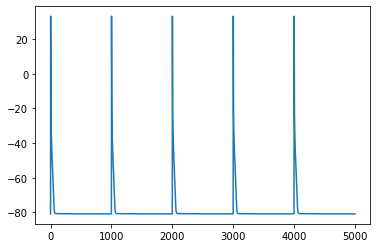

In [28]:
plt.plot(t, v)

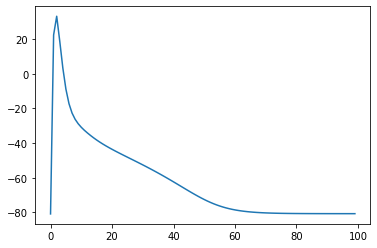

In [30]:
plt.plot(v[-int(CL) - 1: -int(CL) - 1 + 100])